# Text Classification with movie review

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print(tf.__version__)

2.14.0


# Dataset Load

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 3s 0us/step


In [4]:
os.listdir(dataset_dir)

['README', 'test', 'imdbEr.txt', 'train', 'imdb.vocab']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['pos',
 'urls_unsup.txt',
 'urls_neg.txt',
 'neg',
 'unsup',
 'labeledBow.feat',
 'unsupBow.feat',
 'urls_pos.txt']

In [6]:
# `aclImdb/train/pos` 및 `aclImdb/train/neg` 디렉토리에는 각각 단일 영화를 리뷰한 많은 텍스트 파일이 포함
## 그 중 하나를 살펴보자
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
# binary classification을 위해서 class_a, class_b에 해당하는 2개의 폴더가 필요함
## IMDB 데이터세트 안의 추가적인 폴더 initializing
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [8]:
# 레이블이 지정된 tf.data.Dataset를 만든다.
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
# 25,000개 중 80%(또는 20,000개)를 훈련에 사용
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [10]:
# binary classification - negative(0), positive(1)
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train',
                                                         batch_size = batch_size,
                                                         validation_split = 0.2,
                                                         subset='validation',
                                                         seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/test',
                                                          batch_size=batch_size)

Found 25000 files belonging to 2 classes.


# Data preprocessing

In [14]:
# html tag 제거를 위한 함수 정의
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')

  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [15]:
# text vectorization을 위한 layer 생성
## data standardization, tokenization, vectorization
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(standardize=custom_standardization,
                                           max_tokens=max_features,
                                           output_mode='int',
                                           output_sequence_length=sequence_length)

In [16]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)

  return vectorize_layer(text), label

In [18]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]

# 숫자로 바뀐 text를 확인해 보자
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [19]:
# .get_bocabulary()를 이용해서 각 숫자들에 해당하는 token(문자열)을 조회 가능
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [20]:
# text vectorization layer를 train/val/test dataset에 적용
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

# .cache(): 데이터가 디스크에서 로드된 후 메모리에 데이터를 보관
## 모델을 훈련하는 동안 데이터세트로 인해 병목 현상이 발생하지 않기 위함이다.

# .prefetch(): 훈련 중에 데이터 전처리 및 모델 실행과 겹침
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Define

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([layers.Embedding(max_features + 1, embedding_dim),   # 숫자로 encoding된 text를 받아서 각 단어 index에 해당하는 emedding vector 찾음
                             layers.Dropout(0.2),                                 ## vector dimension: (batch, sequence, embedding)
                             layers.GlobalAveragePooling1D(),                     # sequence 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환
                             layers.Dropout(0.2),                                 ## text의 길이가 모두 다르기 때문에 적용해 주는 것!
                             layers.Dense(1)])                                    # 하나의 출력 노드(node)를 가진 fc layer (sigmoid로 0~1 사이의 값 출력)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [25]:
# loss function & optimizer
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [26]:
epochs = 10
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 65s 95ms/step - loss: 0.6620 - binary_accuracy: 0.7001 - val_loss: 0.6125 - val_binary_accuracy: 0.7740
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5466 - binary_accuracy: 0.8026 - val_loss: 0.4971 - val_binary_accuracy: 0.8234
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4434 - binary_accuracy: 0.8452 - val_loss: 0.4194 - val_binary_accuracy: 0.8474
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3778 - binary_accuracy: 0.8658 - val_loss: 0.3732 - val_binary_accuracy: 0.8600
Epoch 5/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3348 - binary_accuracy: 0.8796 - val_loss: 0.3445 - val_binary_accuracy: 0.8690
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3042 - binary_accuracy: 0.8894 - val_loss: 0.3255 - val_binary_accuracy: 0.8722
Epoch 7/10
625/625 [==============================] - 3s 4ms/s

# Model Evaluation & Visualization

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 6s 8ms/step - loss: 0.3099 - binary_accuracy: 0.8740
Loss:  0.3099044859409332
Accuracy:  0.8740400075912476


In [29]:
# model.fit()을 이용했으므로 history에 훈련 중 발생한 결과들이 저장되어있음
## 4개의 지표가 저장되어있음 => loss, binary_accuracy, val_loss, val_binary_accuracy
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

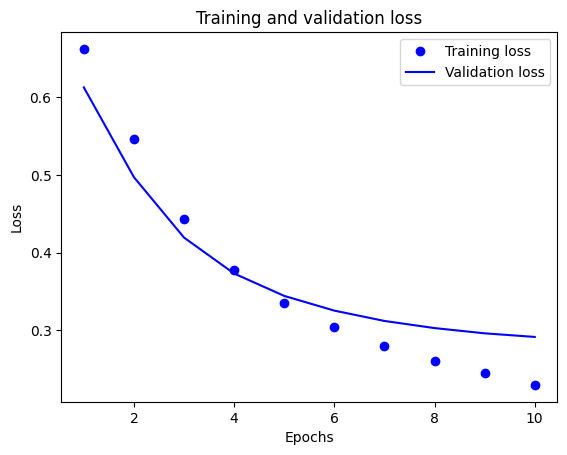

In [30]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

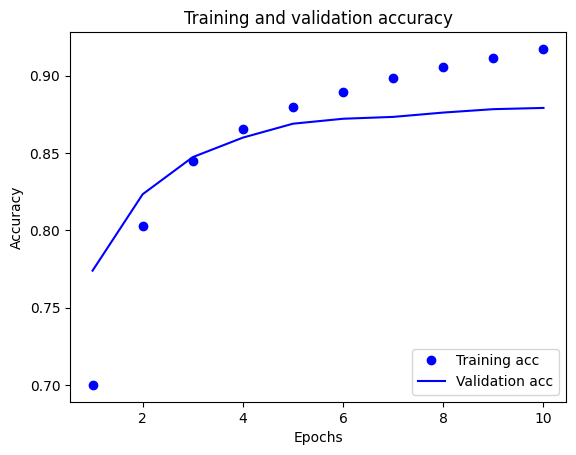

In [31]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Model Save & Performance

In [32]:
# data preprocessing에 사용했던 text vectorization layer(; vectorize_layer)를 model architecture에 추가해줌
export_model = tf.keras.Sequential([vectorize_layer, model, layers.Activation('sigmoid')])

export_model.compile(loss=losses.BinaryCrossentropy(from_logits=False),
                     optimizer="adam",
                     metrics=['accuracy'])

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3099 - accuracy: 0.8740
0.8740400075912476


In [33]:
# 새로운 데이터로 inference => model.predict() 이용
examples = ["The movie was great!", "The movie was okay.", "The movie was terrible..."]

export_model.predict(examples)

1/1 [==============================] - 0s 171ms/step


array([[0.6217796 ],
       [0.44428796],
       [0.35967106]], dtype=float32)